Enter station number (or 'all' for all stations):  all
Enter equipment number (or 'all' for all equipment):  all


C:\Users\admin\AppData\Local\Temp\ipykernel_1892\1967814279.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_footfall = df.resample('H').count()  # Hourly footfall
C:\Users\admin\AppData\Local\Temp\ipykernel_1892\1967814279.py:35: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_footfall = hourly_footfall.asfreq('H')


Epoch 0/100, Loss: 0.0065633352319959416
Epoch 10/100, Loss: 0.004842672438826412
Epoch 20/100, Loss: 0.004771564474919744
Epoch 30/100, Loss: 0.004410562585690059
Epoch 40/100, Loss: 0.004306646551412996
Epoch 50/100, Loss: 0.004152582469812062
Epoch 60/100, Loss: 0.004264550054878262
Epoch 70/100, Loss: 0.00384765705166501
Epoch 80/100, Loss: 0.0037754659861093387
Epoch 90/100, Loss: 0.003672739231011032
Test Loss: 0.004359704608629856


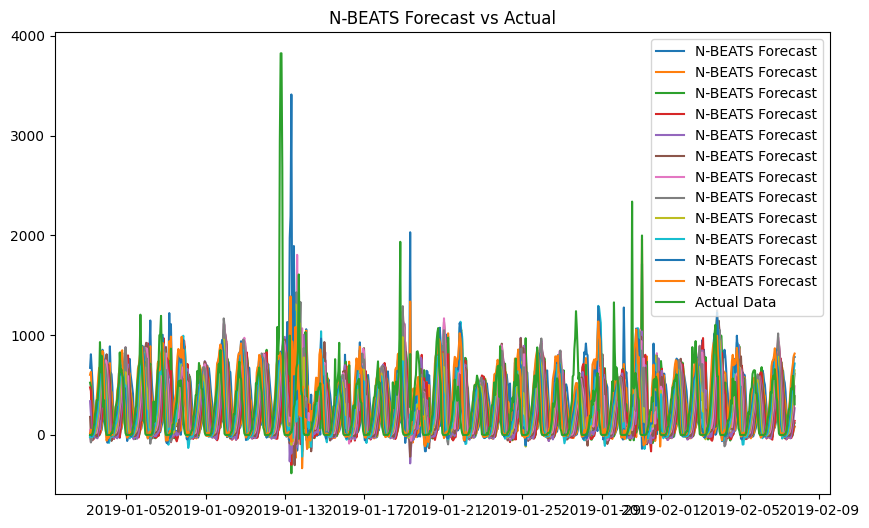

Would you like to save forecasts in separate columns (enter 'separate') or as a single flattened column (enter 'flatten')?  separate


Forecasting completed and saved with separate columns for each horizon.


In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Load Dataset
df = pd.read_csv('transaction.csv')  # Use uploaded dataset

# Data Preprocessing
df['Dt'] = pd.to_datetime(df['Dt'], format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')

# Drop rows with invalid dates if needed
df = df.dropna(subset=['Dt'])

# Set the index to the date column
df.set_index('Dt', inplace=True)

# Filtering based on user input for stn no and EqN
stn_no = input("Enter station number (or 'all' for all stations): ")
eqn_no = input("Enter equipment number (or 'all' for all equipment): ")

# Apply filters
if stn_no.lower() != 'all':
    df = df[df['Sta'] == int(stn_no)]
if eqn_no.lower() != 'all':
    df = df[df['EqN'] == int(eqn_no)]

# Aggregating the Footfall at Hourly Level
hourly_footfall = df.resample('H').count()  # Hourly footfall
hourly_footfall = hourly_footfall.asfreq('H')

# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(hourly_footfall['_id'].values.reshape(-1, 1))

# Hyperparameters
LOOKBACK = 24  # Backcast horizon (input sequence length)
FORECAST_HORIZON = 12  # Forecast horizon (output sequence length)
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.001

# Prepare the data for training
def create_sequences(data, lookback, forecast_horizon):
    x, y = [], []
    for i in range(len(data) - lookback - forecast_horizon + 1):
        x.append(data[i : i + lookback])
        y.append(data[i + lookback : i + lookback + forecast_horizon])
    return np.array(x), np.array(y)

# Split the dataset into training and testing
split_idx = int(len(scaled_data) * 0.8)
train_series, test_series = scaled_data[:split_idx], scaled_data[split_idx:]

# Create sequences for training and testing
X_train, y_train = create_sequences(train_series, LOOKBACK, FORECAST_HORIZON)
X_test, y_test = create_sequences(test_series, LOOKBACK, FORECAST_HORIZON)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# N-BEATS Model Definition
class NBeatsModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim=128):
        super(NBeatsModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input: [batch_size, LOOKBACK] 
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        forecast = self.fc3(x)
        return forecast

# Model, loss function, and optimizer
nbeats_model = NBeatsModel(input_size=LOOKBACK, output_size=FORECAST_HORIZON)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(nbeats_model.parameters(), lr=LEARNING_RATE)

# Training loop
for epoch in range(EPOCHS):
    nbeats_model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        forecast = nbeats_model(X_batch)
        
        # Reshape y_batch to match the forecast shape
        y_batch = y_batch.view(y_batch.size(0), -1)
        
        # Compute the loss
        loss = loss_fn(forecast, y_batch)
        running_loss += loss.item()
        
        # Backpropagation
        loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{EPOCHS}, Loss: {running_loss/len(train_loader)}')

# Testing the model
nbeats_model.eval()
test_loss = 0.0
predictions = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        forecast = nbeats_model(X_batch)
        y_batch = y_batch.view(y_batch.size(0), -1)
        loss = loss_fn(forecast, y_batch)
        test_loss += loss.item()
        predictions.append(forecast)

# Calculate the test loss
print(f'Test Loss: {test_loss/len(test_loader)}')

# Convert predictions back to original scale
predictions = torch.cat(predictions, dim=0).numpy()
predictions_rescaled = scaler.inverse_transform(predictions)

# Plotting the forecast vs actual values
plt.figure(figsize=(10, 6))
plt.plot(hourly_footfall.index[-len(predictions_rescaled):], predictions_rescaled, label='N-BEATS Forecast')
plt.plot(hourly_footfall.index[-len(predictions_rescaled):], scaler.inverse_transform(test_series[-len(predictions_rescaled):]), label='Actual Data')
plt.title("N-BEATS Forecast vs Actual")
plt.legend()
plt.show()

# Define the base path for saving the files
base_path = r'C:\Users\admin\Desktop\airline\sensor-file-ridership\output of sensors'

# Ask user if they want to save forecast in separate columns or as a single column
save_option = input("Would you like to save forecasts in separate columns (enter 'separate') or as a single flattened column (enter 'flatten')? ")

if save_option == 'separate':
    # Create column names for each forecast horizon
    column_names = [f'Predicted_Footfall_t+{i}' for i in range(1, predictions_rescaled.shape[1] + 1)]
    
    # Create DataFrame with separate columns for each forecast horizon
    forecast_df = pd.DataFrame(predictions_rescaled, columns=column_names)
    
    # Save to CSV with separate columns for each horizon
    forecast_df.to_csv(os.path.join(base_path, f'nbeats_forecast_{stn_no}_{eqn_no}_separate.csv'), index=False)
    
    print("Forecasting completed and saved with separate columns for each horizon.")

elif save_option == 'flatten':
    # Flatten the predictions to a single column
    predictions_flattened = predictions_rescaled.flatten()
    
    # Create a DataFrame with a single column
    forecast_df = pd.DataFrame(predictions_flattened, columns=['Predicted_Footfall'])
    
    # Save to CSV with flattened predictions
    forecast_df.to_csv(os.path.join(base_path, f'nbeats_forecast_{stn_no}_{eqn_no}_flattened.csv'), index=False)
    
    print("Forecasting completed and saved with flattened predictions.")

else:
    print("Invalid input! Please enter either 'separate' or 'flatten'.")
